<a href="https://colab.research.google.com/github/Namratha0506/time-seris/blob/main/Time_Series_Data_Analysis_JJ_and_AMZN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# =============================================
# 1. Data Loading and Initial Visualization
# =============================================

def load_data():
     # Load Johnson & Johnson data
    jj = pd.read_csv('jj.csv')

    # Ensure proper date parsing - try different formats if needed
    try:
        jj['date'] = pd.to_datetime(jj['date'], format='%d-%m-%Y')
    except:
        jj['date'] = pd.to_datetime(jj['date'])

    jj.set_index('date', inplace=True)

    # Verify data was loaded before frequency conversion
    print("Raw data after loading:")
    print(jj.head())

    # Convert to quarterly frequency without losing data
    jj = jj.resample('Q').last()  # Takes last value in each quarter

    # Load Amazon data
    amzn = pd.read_csv('AMZN.csv')
    amzn['Date'] = pd.to_datetime(amzn['Date'])
    amzn.set_index('Date', inplace=True)
    amzn = amzn[['Close']].resample('D').mean().ffill()  # Daily frequency

    return jj, amzn

def plot_initial_data(jj, amzn):
    plt.figure(figsize=(15, 8))

    plt.subplot(2, 1, 1)
    jj['data'].plot(title='Johnson & Johnson Quarterly Sales', color='blue')
    plt.ylabel('Sales')

    plt.subplot(2, 1, 2)
    amzn['Close'].plot(title='Amazon Daily Closing Price', color='green')
    plt.ylabel('Price ($)')

    plt.tight_layout()
    plt.savefig('initial_data_plots.png')
    plt.show()

In [ ]:
# =============================================
# 2. Stationarity Testing and Transformation
# =============================================

def test_stationarity(series, name):
    """Perform ADF test and plot ACF/PACF to check stationarity."""
    print(f'\nStationarity Test for {name}')
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    # Ensure enough data for ACF/PACF plots
    lags = min(40, len(series)//2 - 1) if len(series) > 10 else 5
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plot_acf(series.dropna(), lags=lags, ax=plt.gca())
    plt.subplot(2, 1, 2)
    plot_pacf(series.dropna(), lags=lags, ax=plt.gca())
    plt.suptitle(f'ACF/PACF for {name}')
    plt.savefig(f'acf_pacf_{name}.png')
    plt.show()
    return result[1] > 0.05  # True if non-stationary (p > 0.05)

def make_stationary(series, name):
    """Transform series to stationary using log and differencing if needed."""
    # Log transform to stabilize variance (add 1 to avoid log(0))
    log_series = np.log(series + 1)
    if test_stationarity(log_series, f"{name} (Log)"):
        # If still non-stationary, difference once
        diff_series = log_series.diff().dropna()
        if test_stationarity(diff_series, f"{name} (Log + Diff)"):
            print(f"{name} may require further transformation.")
        return diff_series
    return log_series

In [ ]:
# =============================================
# 3. Fourier Decomposition (Unit 4)
# =============================================

def add_fourier_terms(series, period):
    """Add Fourier terms to capture seasonality (e.g., quarterly=4, yearly=252)."""
    t = np.arange(len(series))
    fourier_terms = pd.DataFrame({
        'sin_1': np.sin(2 * np.pi * t / period),
        'cos_1': np.cos(2 * np.pi * t / period)
    }, index=series.index)
    return fourier_terms

In [ ]:
# =============================================
# 4. ARMA Modeling
# =============================================

def find_best_arma(series, max_p=5, max_d=2, max_q=5):
    """Find best ARMA(p,d,q) parameters using AIC."""
    best_aic = np.inf
    best_order = None
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                except:
                    continue
    print(f"Best ARMA order for {series.name}: {best_order}, AIC: {best_aic}")
    return best_order if best_order else (1, 1, 1)

def arma_forecast(series, order, steps, name):
    """Fit ARMA model and forecast 24 months into the future."""
    model = ARIMA(series, order=order)
    model_fit = model.fit()

    # Forecast 24 months (8 quarters for JJ, 730 days for AMZN)
    forecast = model_fit.forecast(steps=steps)
    conf_int = model_fit.get_forecast(steps=steps).conf_int()

    # Generate future dates
    last_date = series.index[-1]
    freq = 'Q' if name == 'Johnson & Johnson' else 'D'
    forecast_dates = pd.date_range(last_date, periods=steps + 1, freq=freq)[1:]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series, label='Historical')
    plt.plot(forecast_dates, forecast, label='Forecast', color='red')
    plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'ARMA Forecast for {name}')
    plt.legend()
    plt.savefig(f'arma_forecast_{name}.png')
    plt.show()

    # Evaluation (if enough historical data exists)
    if len(series) >= steps:
        true_vals = series[-steps:]
        print(f'{name} ARMA MAE:', mean_absolute_error(true_vals, forecast))
        print(f'{name} ARMA RMSE:', np.sqrt(mean_squared_error(true_vals, forecast)))
    return forecast

In [ ]:
# =============================================
# 5. LSTM/GRU Modeling
# =============================================

def prepare_nn_data(series, n_steps):
    """Prepare data for LSTM/GRU with scaling and sequence creation."""
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    X, y = [], []
    for i in range(len(scaled_data) - n_steps):
        X.append(scaled_data[i:i + n_steps, 0])
        y.append(scaled_data[i + n_steps, 0])
    return np.array(X), np.array(y), scaler

def build_lstm_model(n_steps):
    """Build LSTM model with 50 units."""
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(n_steps, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru_model(n_steps):
    """Build GRU model with 50 units."""
    model = Sequential([
        GRU(50, activation='relu', input_shape=(n_steps, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def neural_net_forecast(series, steps, name, model_type='lstm'):
    """Fit LSTM or GRU model and forecast 24 months into the future."""
    # Define lookback period (4 quarters for JJ, 30 days for AMZN)
    n_steps = 4 if name == 'Johnson & Johnson' else 30
    X, y, scaler = prepare_nn_data(series, n_steps)

    # Train-test split (80% train, 20% test)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build and train model
    model = build_lstm_model(n_steps) if model_type == 'lstm' else build_gru_model(n_steps)
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),
              callbacks=[early_stop], verbose=0)

    # Forecast 24 months iteratively
    x_input = X[-1].reshape((1, n_steps, 1))  # Start with last sequence
    forecast = []
    for _ in range(steps):
        yhat = model.predict(x_input, verbose=0)
        forecast.append(yhat[0, 0])
        x_input = np.concatenate((x_input[:, 1:, :], yhat.reshape(1, 1, 1)), axis=1)
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

    # Generate future dates
    last_date = series.index[-1]
    freq = 'Q' if name == 'Johnson & Johnson' else 'D'
    forecast_dates = pd.date_range(last_date, periods=steps + 1, freq=freq)[1:]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series, label='Historical')
    plt.plot(forecast_dates, forecast, label='Forecast', color='red')
    plt.title(f'{model_type.upper()} Forecast for {name}')
    plt.legend()
    plt.savefig(f'{model_type}_forecast_{name}.png')
    plt.show()

    # Evaluation (if enough historical data exists)
    if len(series) >= steps:
        true_vals = series[-steps:]
        print(f'{name} {model_type.upper()} MAE:', mean_absolute_error(true_vals, forecast))
        print(f'{name} {model_type.upper()} RMSE:', np.sqrt(mean_squared_error(true_vals, forecast)))
    return forecast

Raw data after loading:
            data
date            
1960-01-01  0.71
1960-04-01  0.63
1960-07-02  0.85
1960-10-01  0.44
1961-01-01  0.61


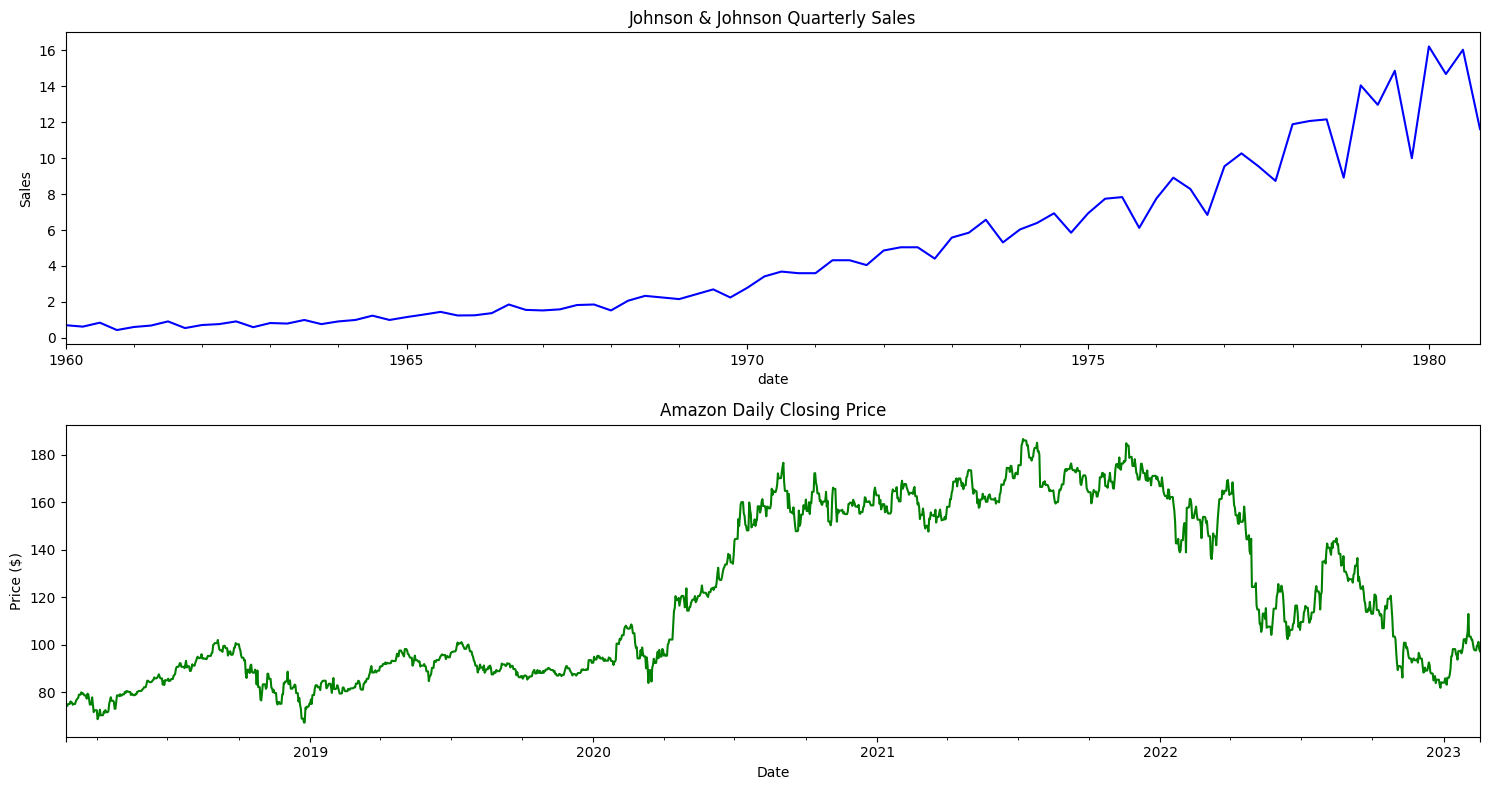


=== Stationarity Tests and Transformation ===

Stationarity Test for Johnson & Johnson (Log)
ADF Statistic: 0.5433248680164178
p-value: 0.9861321024340046
Critical Values: {'1%': np.float64(-3.520713130074074), '5%': np.float64(-2.9009249540740742), '10%': np.float64(-2.5877813777777776)}


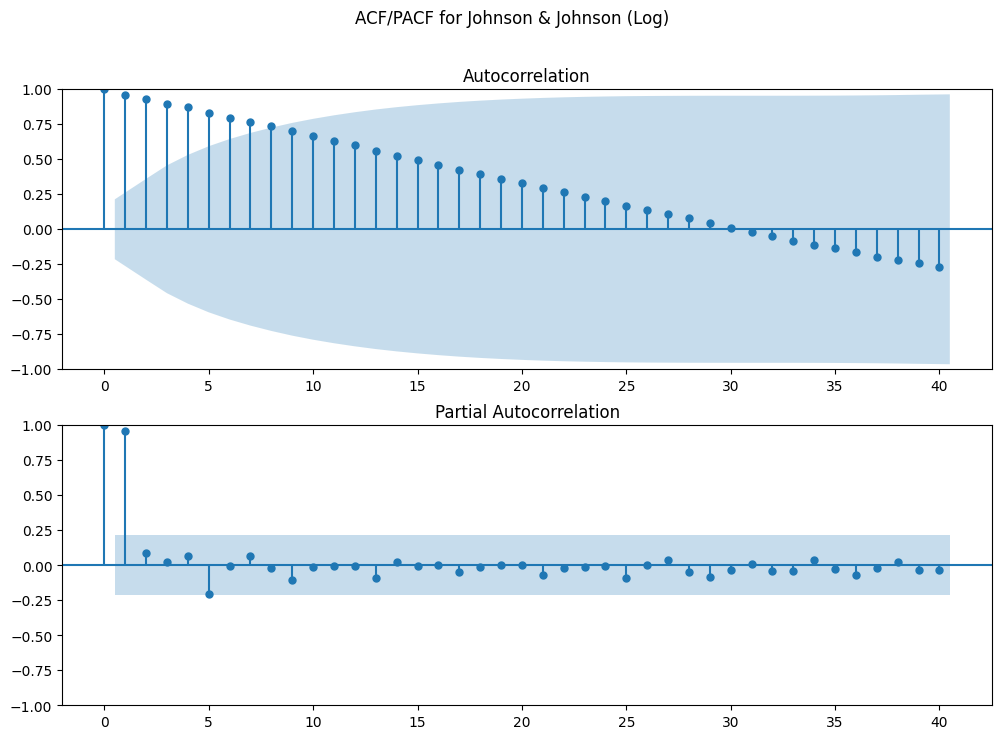


Stationarity Test for Johnson & Johnson (Log + Diff)
ADF Statistic: -2.6947433566046537
p-value: 0.07495232349907278
Critical Values: {'1%': np.float64(-3.520713130074074), '5%': np.float64(-2.9009249540740742), '10%': np.float64(-2.5877813777777776)}


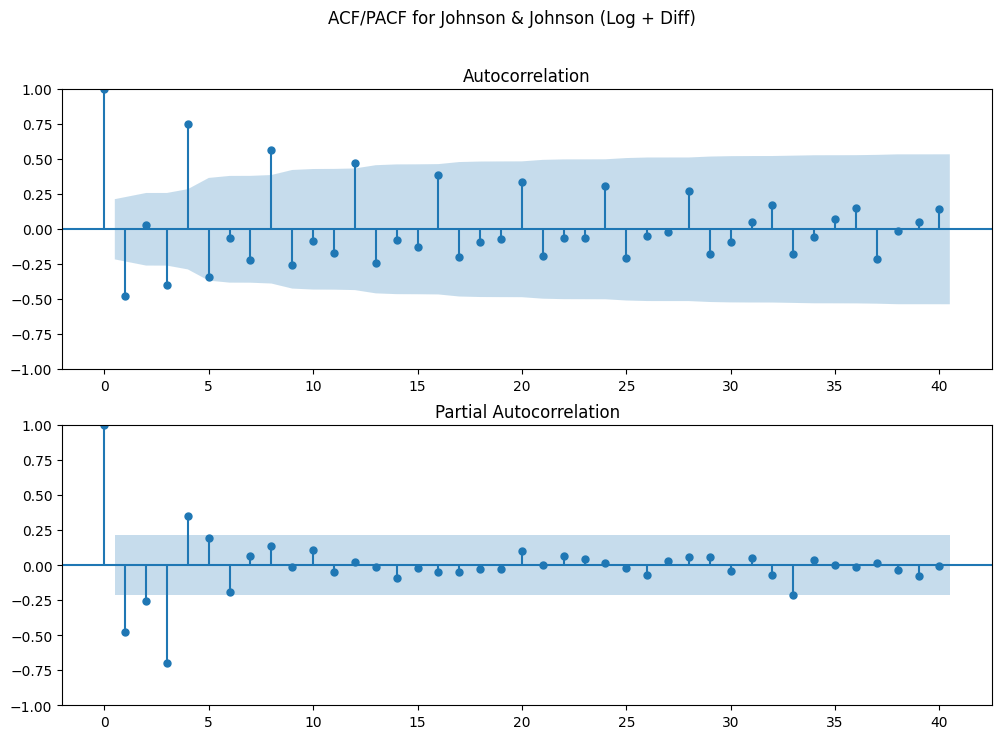

Johnson & Johnson may require further transformation.

Stationarity Test for Amazon (Log)
ADF Statistic: -1.7050637304683485
p-value: 0.42850539727781106
Critical Values: {'1%': np.float64(-3.4339441475744668), '5%': np.float64(-2.8631276157416945), '10%': np.float64(-2.5676151930364455)}


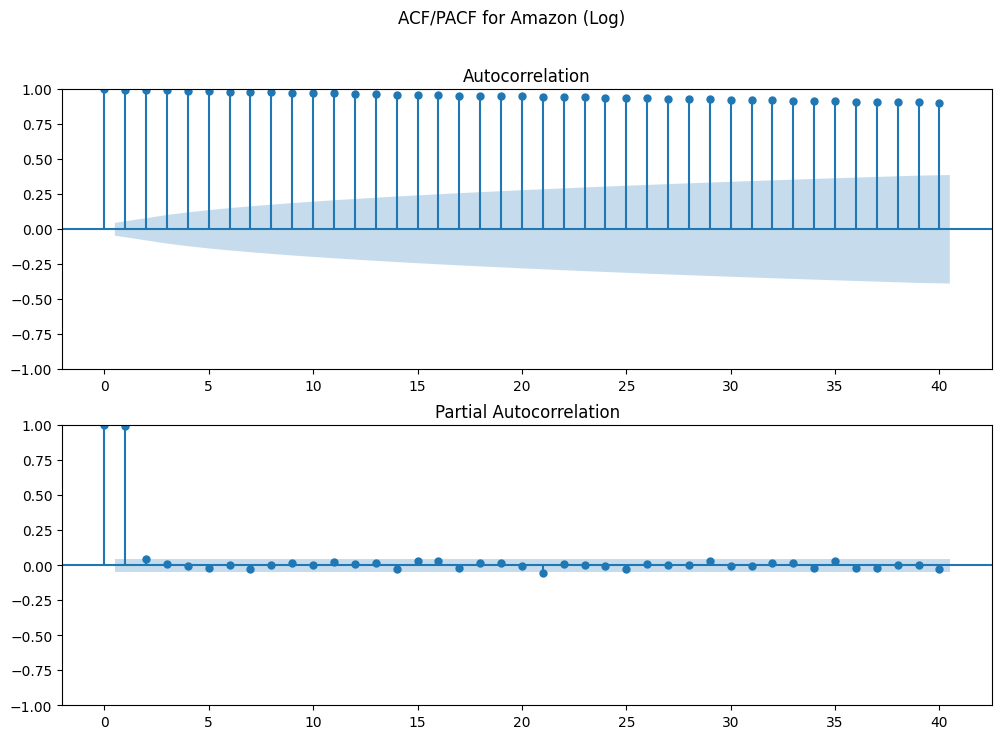


Stationarity Test for Amazon (Log + Diff)
ADF Statistic: -45.21941284822775
p-value: 0.0
Critical Values: {'1%': np.float64(-3.4339441475744668), '5%': np.float64(-2.8631276157416945), '10%': np.float64(-2.5676151930364455)}


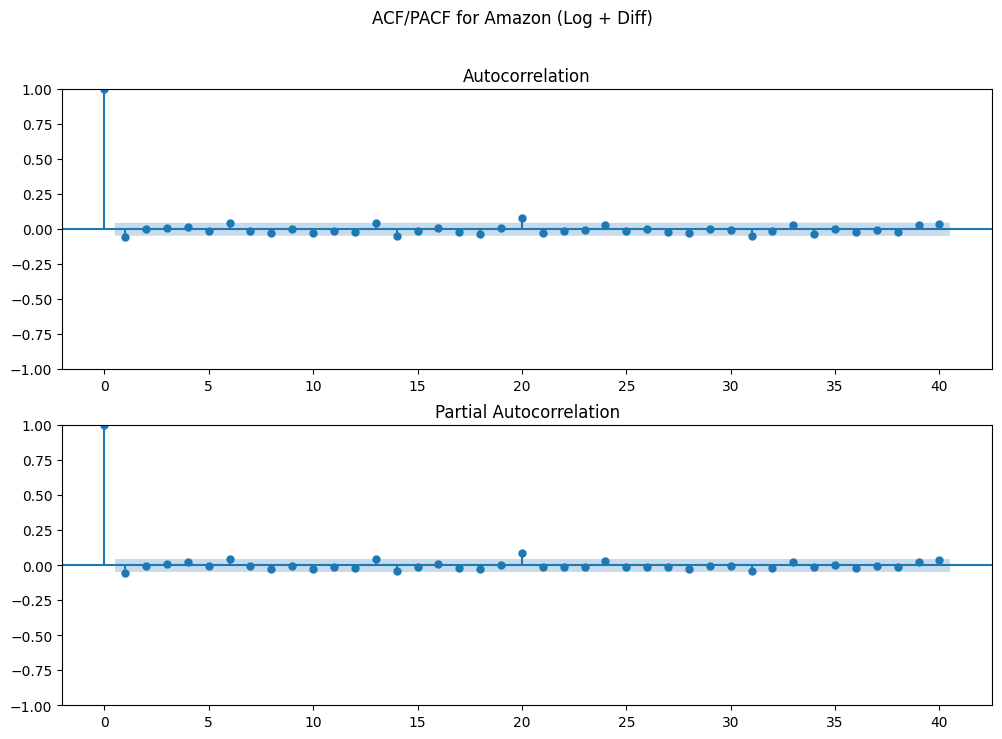


=== ARMA Modeling and Forecasting ===
Best ARMA order for data: (3, 0, 2), AIC: -211.32931260274495


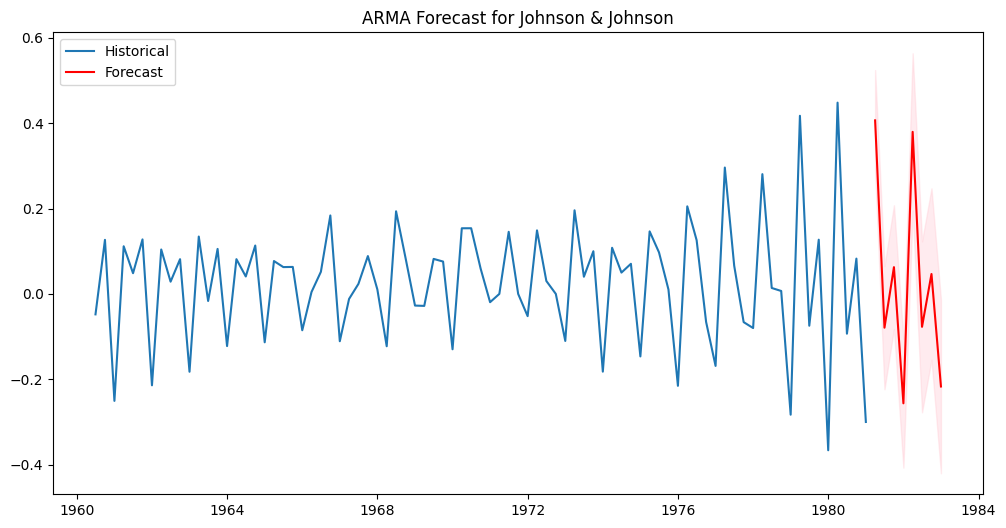

Johnson & Johnson ARMA MAE: 0.04916011765903709
Johnson & Johnson ARMA RMSE: 0.06073220486481995
Best ARMA order for Close: (0, 0, 1), AIC: -9320.93468748909


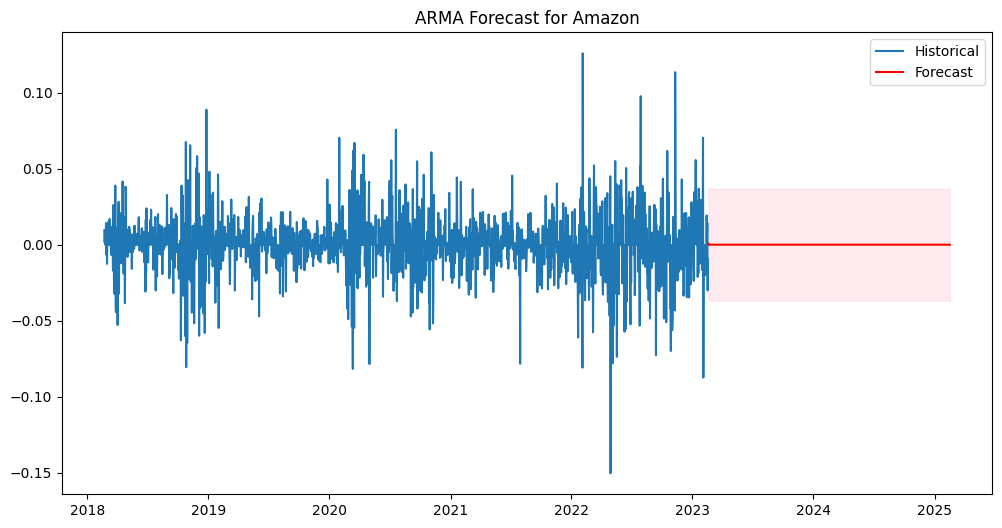

Amazon ARMA MAE: 0.012502697784280804
Amazon ARMA RMSE: 0.021065922155820437

=== LSTM Forecasting ===


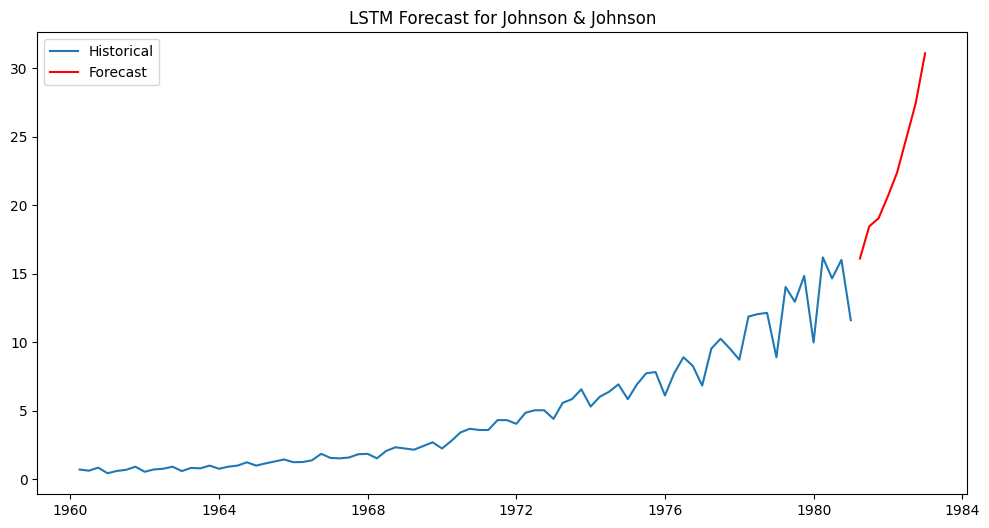

Johnson & Johnson LSTM MAE: 8.728502054214477
Johnson & Johnson LSTM RMSE: 10.125266834085641


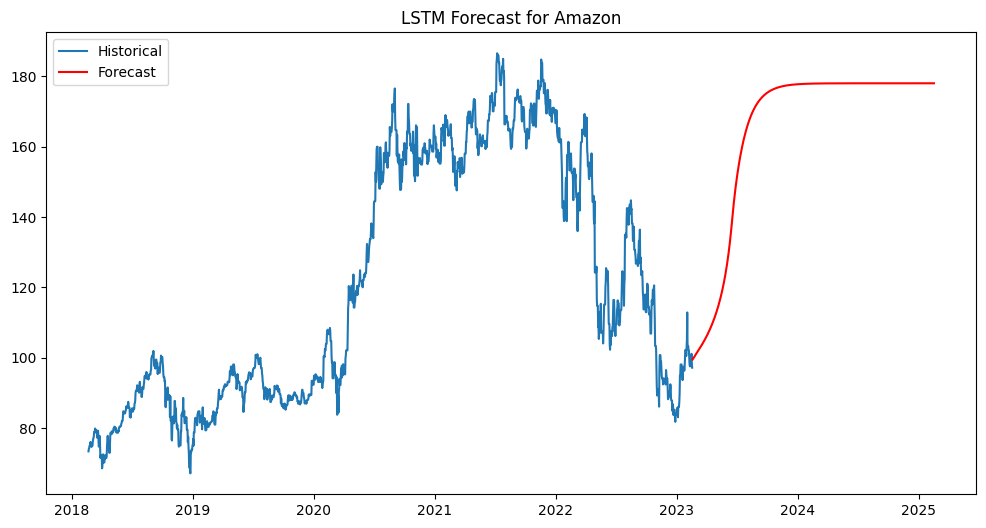

Amazon LSTM MAE: 41.85358820089296
Amazon LSTM RMSE: 50.21792963366104

=== GRU Forecasting ===


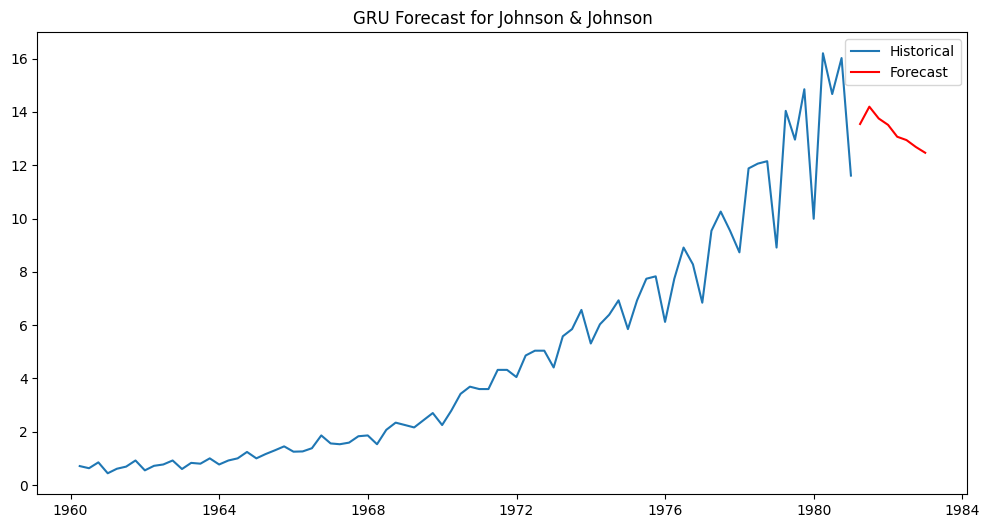

Johnson & Johnson GRU MAE: 1.9251346254348751
Johnson & Johnson GRU RMSE: 2.237211349335573


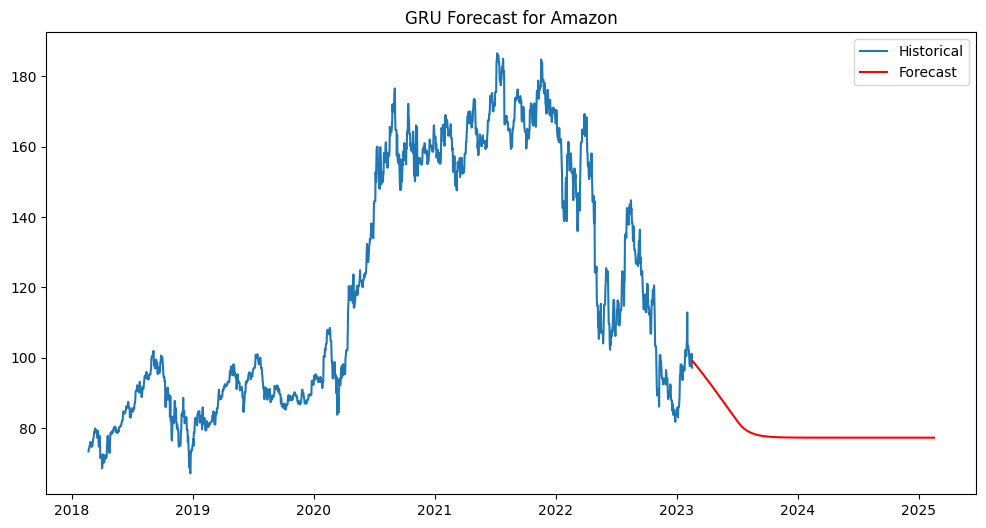

Amazon GRU MAE: 62.28669754975252
Amazon GRU RMSE: 68.36223738821049


In [ ]:
# =============================================
# Main Execution
# =============================================

def main():
    """Execute full time series analysis and forecasting."""
    # Load and plot data
    jj, amzn = load_data()
    if jj is None or amzn is None:
        return
    plot_initial_data(jj, amzn)

    # Stationarity transformation
    print("\n=== Stationarity Tests and Transformation ===")
    jj_stat = make_stationary(jj['data'], 'Johnson & Johnson')
    amzn_stat = make_stationary(amzn['Close'], 'Amazon')

    # Add Fourier terms (quarterly period=4 for JJ, yearly=252 for AMZN daily)
    jj_fourier = add_fourier_terms(jj_stat, period=4)
    amzn_fourier = add_fourier_terms(amzn_stat, period=252)

    # ARMA modeling and forecasting (24 months = 8 quarters for JJ, 730 days for AMZN)
    print("\n=== ARMA Modeling and Forecasting ===")
    jj_arma_order = find_best_arma(jj_stat, max_d=2)
    arma_forecast(jj_stat, jj_arma_order, 8, 'Johnson & Johnson')
    amzn_arma_order = find_best_arma(amzn_stat, max_d=2)
    arma_forecast(amzn_stat, amzn_arma_order, 730, 'Amazon')

    # Neural network modeling and forecasting
    print("\n=== LSTM Forecasting ===")
    neural_net_forecast(jj['data'], 8, 'Johnson & Johnson', 'lstm')
    neural_net_forecast(amzn['Close'], 730, 'Amazon', 'lstm')

    print("\n=== GRU Forecasting ===")
    neural_net_forecast(jj['data'], 8, 'Johnson & Johnson', 'gru')
    neural_net_forecast(amzn['Close'], 730, 'Amazon', 'gru')

if __name__ == "__main__":
    main()